# Visualize and interpret netwas results

7/8/19: use less restrictive filtering critera for gwab and netwas (top 5%)

In [1]:
# import matplotlib
# matplotlib.use('TkAgg')

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns

import mygene
mg = mygene.MyGeneInfo()

# latex rendering of text in graphs
import matplotlib as mpl
mpl.rc('text', usetex = False)
mpl.rc('font', family = 'serif')

% matplotlib inline

import visJS2jupyter.visJS_module
import visJS2jupyter.visualizations

In [2]:
gwas_df = pd.read_csv('/Users/brin/Documents/CCBB_tickets_data/Kelsoe/GWAS_results/daner_pgbd_eur_va_enterm_vf1.meta_good',sep='\s+')
gwas_df.head()

,CHR,SNP,BP,A1,A2,FRQ_A_125,FRQ_U_195,INFO,OR,SE,P,ngt
0,10,chr10:60684,60684,A,C,0.9807,0.9593,0.8468,3.1365,0.6205,0.06544,0
1,10,rs187110906,60969,A,C,0.6425,0.6494,0.6901,0.9647,0.2053,0.86100,0
2,10,chr10:61331,61331,A,G,0.9806,0.9592,0.8460,3.1295,0.6202,0.06586,0
3,10,rs147855157,61372,C,CA,0.7013,0.7184,0.8050,0.9233,0.2014,0.69190,0
4,10,chr10:61419,61419,A,G,0.0624,0.0634,0.4658,1.0020,0.4945,0.99670,0


In [3]:
# load and parse the chromosome and p-value data

# gwas_df = pd.read_csv('/Users/brin/Documents/CCBB_tickets_data/Kelsoe/gwas_for_gwab_eur.tsv',sep='\t')
# gwas_df.head()

In [4]:
# add a column for -log10 pval
gwas_df['-log10pval'] = -np.log10(gwas_df['P'])
gwas_df.head()

,CHR,SNP,BP,A1,A2,FRQ_A_125,FRQ_U_195,INFO,OR,SE,P,ngt,-log10pval
0,10,chr10:60684,60684,A,C,0.9807,0.9593,0.8468,3.1365,0.6205,0.06544,0,1.184157
1,10,rs187110906,60969,A,C,0.6425,0.6494,0.6901,0.9647,0.2053,0.86100,0,0.064997
2,10,chr10:61331,61331,A,G,0.9806,0.9592,0.8460,3.1295,0.6202,0.06586,0,1.181378
3,10,rs147855157,61372,C,CA,0.7013,0.7184,0.8050,0.9233,0.2014,0.69190,0,0.159957
4,10,chr10:61419,61419,A,G,0.0624,0.0634,0.4658,1.0020,0.4945,0.99670,0,0.001436


In [5]:
def manhattan_plot(gwas_df,figsize=(15,6),snps_to_highlight=[],highlight_label=''):
    '''
    gwas_df must have fields CHR, BP, P, -log10pval, SNP
    '''
    # only plot points with pvalue < 0.01
    
    plt.figure(figsize=figsize)
    
    gwas_p01 = gwas_df[gwas_df['P']<0.01]
    chroms = list(np.sort(gwas_p01['CHR'].unique().tolist()))
    chrom_offset = 0
    xtick_pos = []
    xtick_label = []
    for c in chroms:
        gwas_c = gwas_p01[gwas_p01['CHR']==c]
        gwas_c = gwas_c.sort_values('BP')
        
        xtemp = gwas_c['BP']+chrom_offset
        ptemp = gwas_c['-log10pval']
        
        if (c%2)==0:
            color = 'k'
        else:
            color='gray'
        
        plt.plot(xtemp,ptemp,'.',color=color,label='')
        
        max_bp = gwas_c['BP'].max()
        min_bp = gwas_c['BP'].min()
        
        xtick_pos.append((max_bp-min_bp)/2.0+chrom_offset)
        xtick_label.append(str(c))
        
        # look for focal_snps in gwas_c
        color_list = ['y','r','green']
        len_snps = len(snps_to_highlight)

        for w in range(len_snps):
            focal_snps = snps_to_highlight[w]
            snps_in_c = list(np.intersect1d(gwas_c['SNP'].tolist(),focal_snps))
            if len(snps_in_c)>0:

                gwas_c.index=gwas_c['SNP'].tolist() # reindex
                x_snps = gwas_c.loc[snps_in_c]['BP']+chrom_offset
                p_snps = gwas_c.loc[snps_in_c]['-log10pval']

                color = color_list[w]
                plt.plot(x_snps,p_snps,'*',color=color,label=highlight_label[w])
            
        
        
        
        
        chrom_offset+=max_bp
        
    plt.xticks(xtick_pos,xtick_label)
    plt.xlabel('chromosome',fontsize=16)
    plt.ylabel('-log10(p)',fontsize=16)
    plt.hlines(5.0,-1000,3E9,linestyles='--',label='suggestive')
    plt.hlines(7.0,-1000,3E9,linestyles='--',colors='r',label='strong evidence')
    plt.legend(loc='best')

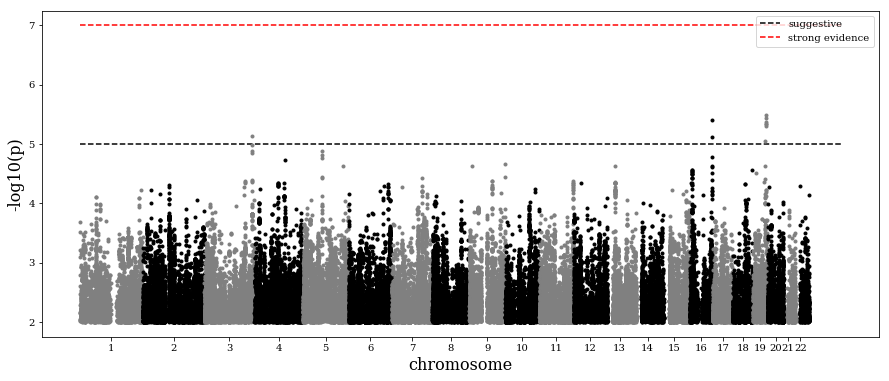

In [317]:
manhattan_plot(gwas_df)
plt.savefig('../figures/manhattan_plot.pdf',bbox_inches='tight',dpi=300)
plt.savefig('../figures/manhattan_plot.png',bbox_inches='tight',dpi=300)

In [159]:
np.log10(1E-7)

-7.0

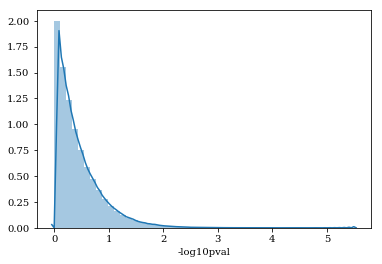

In [330]:
sns.distplot(gwas_df['-log10pval'])

In [331]:
# qq plot inspired by https://www.broadinstitute.org/files/shared/diabetes/scandinavs/qqplot.R
observed = gwas_df['-log10pval'].copy(deep=True)
observed = observed.sort_values(ascending=False)
expected = range(1,len(gwas_df)+1)
lexp = -(np.log10(np.divide(expected,(len(expected)+1.0))))

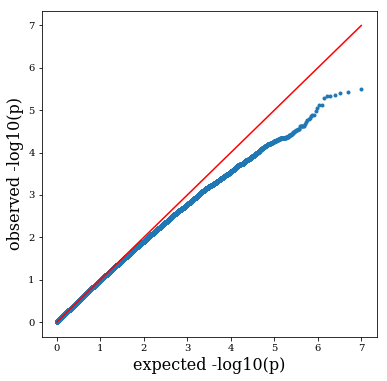

In [334]:
plt.figure(figsize=(6,6))
plt.plot(lexp,observed.tolist(),'.')
plt.plot([0,7],[0,7],'r-')
plt.xlabel('expected -log10(p)',fontsize=16)
plt.ylabel('observed -log10(p)',fontsize=16)
plt.savefig('../figures/Q-Q_plot.png',dpi=300,bbox_inches='tight')

# Load the VEGAS results

In [6]:
vegas_df = pd.read_csv('../VEGAS2/vegas_results_lithium_bipolar_eur.v2out',sep=' ')
vegas_df = vegas_df.sort_values('Pvalue',ascending=True)
vegas_df.head(10)

,Chr,Gene,nSNPs,nSims,Start,Stop,Test,Pvalue,TopSNP,TopSNP-pvalue
0,3,DNAJB11,99,1000000.0,186278464,186313589,872.284807,0.000178,rs2280388,0.000062
1,3,TBCCD1,104,1000000.0,186253855,186298332,762.595327,0.000233,rs2280388,0.000062
2,19,ZNF431,137,1000000.0,21314839,21378805,704.975901,0.000243,rs2358807,0.000411
3,3,SHOX2,64,1000000.0,157803799,157833952,453.393877,0.000349,rs1879803,0.000858
4,8,PDGFRL,632,1000000.0,17423941,17510642,1820.608562,0.000754,rs11203877,0.000178
5,13,UBL3,252,1000000.0,30328544,30434820,1383.415194,0.000847,rs1927193,0.000044
6,6,SRF,79,100000.0,43129032,43159244,442.075107,0.001000,rs6458327,0.000452
7,19,MIR638,61,100000.0,10819079,10839179,369.255427,0.001080,rs8112837,0.001086
8,19,LOC284412,22,100000.0,37746840,37769912,82.077441,0.001090,rs7246657,0.008060
9,5,DIMT1,78,100000.0,61674350,61709728,391.271030,0.001140,rs247257,0.000347


In [7]:
vegas_df.index=vegas_df['Gene']
vegas_df.loc[['TENM4','NTRK2']]

,Chr,Gene,nSNPs,nSims,Start,Stop,Test,Pvalue,TopSNP,TopSNP-pvalue
Gene,,,,,,,,,,
TENM4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NTRK2,9.0,NTRK2,995.0,1000.0,87273372.0,87651985.0,1263.942679,0.203796,rs1443443,0.003293


In [8]:
# permute the vegas_results
# permuted_genes = vegas_df['Gene'].tolist()
# np.random.shuffle(permuted_genes)
# vegas_permuted = vegas_df.copy(deep=True)
# vegas_permuted['Gene']=permuted_genes
# vegas_permuted.to_csv('../vegas_permuted.txt',sep='\t',header=False,index=False)
# vegas_permuted.head()

In [9]:
# print(sum(vegas_df['Pvalue']<0.001))
# for g in vegas_df[vegas_df['Pvalue']<0.001]['Gene'].tolist():
#     print(g)

# 7/8/19: vegas top 5% (lowest 5% p-vals)
p95_vegas = np.percentile(vegas_df['TopSNP-pvalue'],5)
print(len(vegas_df))
print(sum(vegas_df['TopSNP-pvalue']<p95_vegas))
vegas_filtered = vegas_df[vegas_df['TopSNP-pvalue']<p95_vegas]
g_vegas = vegas_filtered['Gene'].tolist()
print(len(g_vegas))

23582
1180
1180


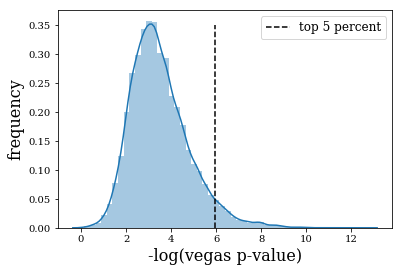

In [33]:
sns.distplot(-np.log(vegas_df['TopSNP-pvalue']))
plt.plot([-np.log(p95_vegas),-np.log(p95_vegas)],[0,.35],'k--',label='top 5 percent')
plt.ylabel('frequency',fontsize=16)
plt.xlabel('-log(vegas p-value)',fontsize=16)
plt.legend(fontsize=12,loc='upper right')
# plt.savefig('../analysis_results/190712/vegas_neglogPval_distribution_top5percent.png',dpi=300,bbox_inches='tight')

In [10]:
vegas_df.index=vegas_df['Gene']

vegas_netwas = vegas_df.loc[g_netwas] 
#vegas_netwas = vegas_netwas[vegas_netwas['TopSNP-pvalue']<0.05] # further filter by TopSNP-pval
vegas_netwas

NameError: name 'g_netwas' is not defined

# Load the netwas results

Useful description of algorithm here: http://humanbase.readthedocs.io/en/latest/netwas.html#

NetWAS trains a support vector machine classifier using nominally significant (P < 0.01) genes as positive examples and 10,000 randomly selected non-significant (P ≥ 0.01) genes as negatives. The classifier is constructed using a tissue network relevant to a disease (e.g. kidney for hypertension), where the features of the classifier are the edge weights of the labeled examples to all the genes in the network. Genes are re-ranked using their distance from the hyperplane, which represent a network-based prioritization of a GWAS, termed NetWAS.

In [11]:
# -------- Load brain netwas results ------------------------------------------------
netwas_df = pd.read_csv('../NETWAS_results/netwas_results_180202.txt',sep='\t',
                       skiprows=3,names=['gene','training_set','netwas_score'])
# -----------------------------------------------------------------------------

# -------- Load kidney netwas results ------------------------------------------------
# netwas_df = pd.read_csv('../NETWAS_results/netwas_kidney_results_180205.txt',sep='\t',
#                        skiprows=3,names=['gene','training_set','netwas_score'])
# -----------------------------------------------------------------------------

# -------- Or load the permuted results ---------------------------------------
# netwas_df = pd.read_csv('../NETWAS_results/netwas_permuted_180205.txt',sep='\t',
#                        skiprows=3,names=['gene','training_set','netwas_score'])
# -----------------------------------------------------------------------------

netwas_df = netwas_df.sort_values('netwas_score',ascending=False)
netwas_df.head()

,gene,training_set,netwas_score
25,MRPS35,-1.0,0.495508
26,EIF3E,-1.0,0.480241
27,NDUFA2,-1.0,0.470991
28,RPS21,-1.0,0.465470
29,EIF3D,-1.0,0.414218


In [12]:
#... how do these numbers add up??
print(sum(netwas_df['training_set']==1))
print(sum(netwas_df['training_set']==-1))
print(sum(netwas_df['training_set']==0))

146
16716
2402


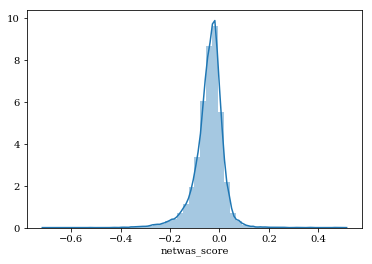

In [13]:
sns.distplot(netwas_df['netwas_score'].dropna())

In [14]:
# how do all genes > .2 perform?
# netwas_filtered = netwas_df[(netwas_df['netwas_score']>.1)]
# g_netwas = netwas_filtered['gene'].tolist()
# print(len(netwas_filtered))
# for g in netwas_filtered['gene'].tolist():
#     print(g)

# update 7/8/19: take top 5% of all netwas genes
p95 = np.percentile(netwas_df['netwas_score'].dropna(),95)

netwas_filtered = netwas_df[netwas_df['netwas_score']>p95]
g_netwas = netwas_filtered['gene'].tolist()
print(len(g_netwas))

964


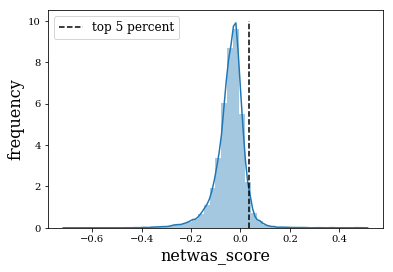

In [22]:
sns.distplot(netwas_df['netwas_score'].dropna())
plt.plot([p95,p95],[0,10],'k--',label='top 5 percent')
plt.ylabel('frequency',fontsize=16)
plt.xlabel('netwas_score',fontsize=16)
plt.legend(fontsize=12,loc='upper left')
# plt.savefig('../analysis_results/190712/netwas_distribution_top5percent.png',dpi=300,bbox_inches='tight')

# Load the GWAB results

In [23]:
gwab_df = pd.read_csv('../GWAB/bipolar/gwap_eur.output',sep='\t')
gwab_df.index=gwab_df['Gene_Symbol']
gwab_df.head(25)

,# Entrez_Gene_ID,Gene_Symbol,GWAB_Score
Gene_Symbol,,,
UBC,7316,UBC,26.441133
APP,351,APP,18.161573
SUMO1,7341,SUMO1,15.222024
HSP90AA1,3320,HSP90AA1,15.164895
GRB2,2885,GRB2,14.811854
HDAC1,3065,HDAC1,13.843159
HDAC2,3066,HDAC2,13.207057
VCP,7415,VCP,12.801652
HSP90AB1,3326,HSP90AB1,12.598357


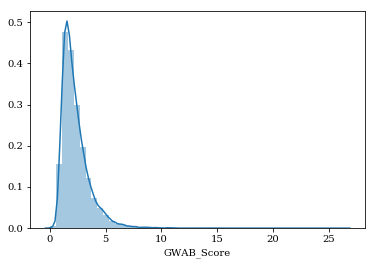

In [24]:
sns.distplot(gwab_df['GWAB_Score'])

In [26]:
# gwab_thresh = 8
# gwab_genes =  gwab_df[gwab_df['GWAB_Score']>gwab_thresh].index.tolist()
# print(len(gwab_genes))
# for g in gwab_genes:
#     print(g)

# update 7/8/19: take the top 5%
p95_gwab = np.percentile(gwab_df['GWAB_Score'].tolist(),95)
gwab_genes = gwab_df[gwab_df['GWAB_Score']>p95_gwab].index.tolist()
print(len(gwab_genes))

1119


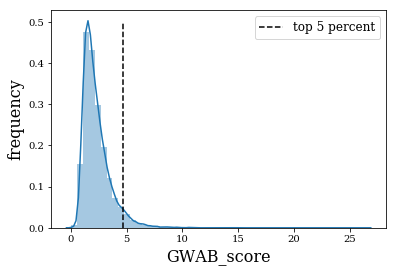

In [28]:
sns.distplot(gwab_df['GWAB_Score'])
plt.plot([p95_gwab,p95_gwab],[0,.5],'k--',label='top 5 percent')
plt.ylabel('frequency',fontsize=16)
plt.xlabel('GWAB_score',fontsize=16)
plt.legend(fontsize=12,loc='upper right')
# plt.savefig('../analysis_results/190712/GWAB_distribution_top5percent.png',dpi=300,bbox_inches='tight')

In [30]:
gwab_df.head()

,# Entrez_Gene_ID,Gene_Symbol,GWAB_Score
Gene_Symbol,,,
UBC,7316,UBC,26.441133
APP,351,APP,18.161573
SUMO1,7341,SUMO1,15.222024
HSP90AA1,3320,HSP90AA1,15.164895
GRB2,2885,GRB2,14.811854


In [27]:
vegas_df.loc[gwab_genes][['TopSNP','TopSNP-pvalue']].sort_values('TopSNP-pvalue').head()

,TopSNP,TopSNP-pvalue
Gene,,
LRRC4B,rs11881006,0.000003
ASPDH,rs112574234,0.000004
AHSG,rs62291986,0.000010
ABAT,rs3095514,0.000027
MLF1,rs1656368,0.000042


In [34]:
netwas_df.head()

,gene,training_set,netwas_score
25,MRPS35,-1.0,0.495508
26,EIF3E,-1.0,0.480241
27,NDUFA2,-1.0,0.470991
28,RPS21,-1.0,0.465470
29,EIF3D,-1.0,0.414218


In [39]:
# 7/8/19: save the new results
# vegas_df.loc[gwab_genes][['Chr','nSNPs','Pvalue','TopSNP','TopSNP-pvalue']].sort_values('TopSNP-pvalue').join(gwab_df.loc[gwab_genes]['GWAB_Score']).to_csv('gwab_genes_5percent_190708.tsv',sep='\t')
# netwas_df.index=netwas_df['gene']
# vegas_df.loc[g_netwas][['Chr','nSNPs','Pvalue','TopSNP','TopSNP-pvalue']].sort_values('TopSNP-pvalue').join(netwas_df.loc[g_netwas]['netwas_score']).to_csv('netwas_genes_5percent_190708.tsv',sep='\t')
# vegas_df.loc[g_vegas][['Chr','nSNPs','Pvalue','TopSNP','TopSNP-pvalue']].sort_values('TopSNP-pvalue').to_csv('vegas_sig_genes_5percent_190708.tsv',sep='\t')

# Ideas for visualization:

- plot old rank and new rank
- GO enrichment

- make a subnewtork out of reprioritized (GWAB score > ~7)
- recreate network figure from "GWAB: a web server for the network-based boosting of human genome-wide association data"

In [166]:
old_rank = pd.Series(range(len(vegas_df)),index=vegas_df.index.tolist())

new_rank = pd.Series(range(len(netwas_df)),index=netwas_df['gene'].tolist())

In [173]:
vegas_df.index = vegas_df['Gene']
vegas_df.loc[g_netwas][['TopSNP','TopSNP-pvalue']].sort_values('TopSNP-pvalue')

,TopSNP,TopSNP-pvalue
Gene,,
UQCRH,rs11588062,0.000392
OXA1L,rs67399634,0.000549
IPO7,rs12362894,0.001400
TOR1A,rs13297609,0.001752
EIF3F,rs75667068,0.003515
GRN,rs78403836,0.004899
COX6B1,rs117704954,0.005375
COX7A2L,rs72798537,0.005742
RPS21,rs6061501,0.008813


## Load STRING

In [209]:
# load STRING database
import sys
sys.path.append('/Users/brin/Google_Drive/UCSD/cluster_code/')
import load_interactomes
import py2cytoscape


In [193]:
G_str = load_interactomes.load_STRING('/Users/brin/Google_Drive/UCSD/CCBB_tickets/CTRI/Rissman/interactomes/string_human/9606.protein.links.v10.txt',
                                     conf_thresh=700,species='human')

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-15478...done.
Finished.
124 input query terms found dup hits:
	[(u'ENSP00000420405', 2), (u'ENSP00000331172', 2), (u'ENSP00000353820', 3), (u'ENSP00000447879', 2),
750 input query terms found no hit:
	[u'ENSP00000265335', u'ENSP00000393912', u'ENSP00000361280', u'ENSP00000362398', u'ENSP00000338190',
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
ENSP00000000233       ARF5
ENSP00000000412       M6PR
ENSP00000000442      ESRRA
ENSP00000001008      FKBP4
ENSP00000001146    CYP26B1
ENSP00000002125    NDUFAF7
ENSP00000002165      FUC

# Draw the network

In [206]:
# find the change in rank
vegas_df = vegas_df.sort_values('Pvalue',ascending=True)
vegas_df['rank']=range(len(vegas_df))
vegas_df.head()

gwab_df = gwab_df.sort_values('GWAB_Score',ascending=False)
gwab_df['rank']=range(len(gwab_df))
gwab_df.head()

,# Entrez_Gene_ID,Gene_Symbol,GWAB_Score,rank
Gene_Symbol,,,,
UBC,7316,UBC,26.441133,0
APP,351,APP,18.161573,1
SUMO1,7341,SUMO1,15.222024,2
HSP90AA1,3320,HSP90AA1,15.164895,3
GRB2,2885,GRB2,14.811854,4


,gene,training_set,netwas_score
25,MRPS35,-1.0,0.495508
26,EIF3E,-1.0,0.480241
27,NDUFA2,-1.0,0.470991
28,RPS21,-1.0,0.465470
29,EIF3D,-1.0,0.414218


gene               UQCRH
training_set          -1
netwas_score    0.208221
Name: UQCRH, dtype: object

In [344]:
netwas_df.head()

,gene,training_set,netwas_score
25,MRPS35,-1.0,0.495508
26,EIF3E,-1.0,0.480241
27,NDUFA2,-1.0,0.470991
28,RPS21,-1.0,0.465470
29,EIF3D,-1.0,0.414218


In [227]:
G_boost = nx.subgraph(G_str,gwab_genes)
gwab_no_nans = [gwab_df.loc[n]['GWAB_Score'] if not np.isnan(gwab_df.loc[n]['GWAB_Score']) else -1 for n in G_boost.nodes()]
nx.set_node_attributes(G_boost,'gwab_score',
                       dict(zip(G_boost.nodes(),gwab_no_nans)))
topSNP_no_nans = [str(vegas_df.loc[n]['TopSNP']) if n in vegas_df.index else 'None' for n in G_boost.nodes()]
nx.set_node_attributes(G_boost,'TopSNP',
                       dict(zip(G_boost.nodes(),topSNP_no_nans)))
topP_no_nans = [-np.log(vegas_df.loc[n]['TopSNP-pvalue']) if n in vegas_df.index else -1 for n in G_boost.nodes()]
nx.set_node_attributes(G_boost,'-logTopSnpPval',
                       dict(zip(G_boost.nodes(),topP_no_nans)))

delta_rank = vegas_df.loc[G_boost.nodes()]['rank']-gwab_df.loc[G_boost.nodes()]['rank']
delta_rank_no_nans = [d if not np.isnan(d) else 0.0 for d in delta_rank]
nx.set_node_attributes(G_boost,'delta_rank',dict(zip(G_boost.nodes(),delta_rank_no_nans)))

print(len(G_boost.nodes()))
print(len(G_boost.edges()))
G_boost.nodes(data=True)[0:5]

87
513


[('TMOD1',
  {'-logTopSnpPval': 6.2251636123617082,
   'TopSNP': 'rs7863943',
   'delta_rank': 17611.0,
   'gwab_score': 9.0968124299999999}),
 ('HSPA4',
  {'-logTopSnpPval': 3.6351491316929683,
   'TopSNP': 'rs77319646',
   'delta_rank': 1501.0,
   'gwab_score': 8.0568199800000002}),
 ('SUMO1',
  {'-logTopSnpPval': 3.9643694858003551,
   'TopSNP': 'rs72923074',
   'delta_rank': 11527.0,
   'gwab_score': 15.222024340000001}),
 ('SUMO3',
  {'-logTopSnpPval': 5.3269226235583691,
   'TopSNP': 'rs79119995',
   'delta_rank': 8229.0,
   'gwab_score': 10.076832749999999}),
 ('SUMO2',
  {'-logTopSnpPval': 3.6896797742847016,
   'TopSNP': 'rs138046159',
   'delta_rank': 16515.0,
   'gwab_score': 10.81670306})]

In [228]:
# export the network to cytoscape format
from py2cytoscape import util
import json

G_json = util.from_networkx(G_boost)

with open('G_boost_gwab.json','w') as outfile:
    json.dump(G_json,outfile)


Gene
UBC         rs142622917
APP            rs363999
SUMO1        rs72923074
HSP90AA1    rs145643636
GRB2        rs144626626
Name: TopSNP, dtype: object

In [251]:
gwab_snps = vegas_df.loc[gwab_genes].dropna()['TopSNP']
gwas_df.index=gwas_df['SNP']
gwas_df.loc[gwab_snps.tolist()].head()

,CHR,SNP,BP,A1,A2,FRQ_A_125,FRQ_U_195,INFO,OR,SE,P,ngt,-log10pval
SNP,,,,,,,,,,,,,
rs142622917,12,rs142622917,125387895,A,G,0.0439,0.0122,0.8408,4.8378,0.6278,0.012040,0,1.919374
rs363999,21,rs363999,27548505,C,G,0.0482,0.0103,1.0984,4.9486,0.5975,0.007441,0,2.128369
rs72923074,2,rs72923074,203112661,A,T,0.6882,0.7702,1.0002,0.6462,0.1862,0.018980,0,1.721704
rs145643636,14,rs145643636,102589154,A,G,0.1526,0.0744,0.8914,2.5500,0.2909,0.001290,0,2.889410
rs144626626,17,rs144626626,73411628,T,C,0.0468,0.0179,0.8927,3.1379,0.5231,0.028820,0,1.540306


In [338]:
netwas_snps = vegas_df.loc[g_netwas].dropna()['TopSNP']
gwas_df.index=gwas_df['SNP']
gwas_df.loc[netwas_snps.tolist()].head()

,CHR,SNP,BP,A1,A2,FRQ_A_125,FRQ_U_195,INFO,OR,SE,P,ngt,-log10pval
SNP,,,,,,,,,,,,,
rs77474622,12,rs77474622,27882080,T,C,0.9310,0.8919,0.7961,1.8275,0.3403,0.076420,0,1.116793
rs381039,8,rs381039,109204502,A,C,0.1960,0.1379,0.8976,1.6268,0.2334,0.037090,0,1.430743
rs113286474,5,rs113286474,140036243,A,G,0.9531,0.9789,0.9065,0.4146,0.4918,0.073410,0,1.134245
rs6061501,20,rs6061501,60953396,T,C,0.9755,0.9270,0.9216,3.4516,0.4730,0.008813,0,2.054876
rs6519014,22,rs6519014,36922743,A,C,0.1069,0.1605,0.7746,0.5651,0.2926,0.051060,0,1.291919


In [339]:
len(netwas_snps)

126

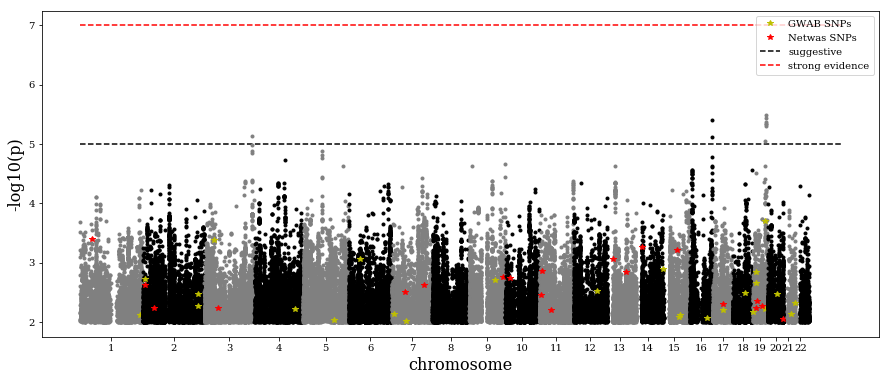

In [341]:
manhattan_plot(gwas_df,snps_to_highlight = [gwab_snps.tolist(),netwas_snps.tolist()],
               highlight_label=['GWAB SNPs','Netwas SNPs'])
plt.savefig('../figures/manhattan_plot_GWAB_NETWAS.pdf')
plt.savefig('../figures/manhattan_plot_GWAB_NETWAS.png',dpi=300,bbox_inches='tight')

In [288]:
np.shape([gwab_snps.tolist(),gwab_snps.tolist()])

(2, 83)

# Write out a table for input to KEGG visualization

In [314]:
vegas_sig_genes = vegas_df[vegas_df['Pvalue']<0.01].index.tolist()
genes_union = list(set.union(set(gwab_genes),set(g_netwas),set(vegas_sig_genes)))
boosting_df = pd.DataFrame(np.zeros((len(genes_union),3)),index=genes_union,columns=['vegas','gwab','netwas'])
boosting_df['vegas'].loc[vegas_sig_genes]=1
boosting_df['gwab'].loc[gwab_genes]=1
boosting_df['netwas'].loc[g_netwas]=1

boosting_df.to_csv('boosting_df.csv',sep='\t')

boosting_df.head()

,vegas,gwab,netwas
TRAPPC2L,0.0,0.0,1.0
LOC100996447,1.0,0.0,0.0
UBL3,1.0,0.0,0.0
HSPA4,0.0,1.0,0.0
SUMO1,0.0,1.0,0.0


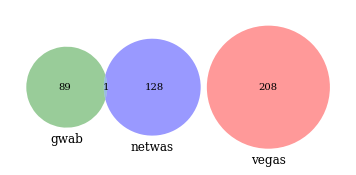

In [315]:
import matplotlib_venn
matplotlib_venn.venn3([set(vegas_sig_genes),set(gwab_genes),set(g_netwas)],set_labels=['vegas','gwab','netwas'])
plt.savefig('../figures/overlap_gwab_netwas_vegas.pdf',bbox_inches='tight',dpi=300)

# Load the RNAseq results


In [319]:
rna_df = pd.read_excel('../DE_Genes_Li and CTRL_LRvsNR_for_Katie.xlsx',index_col='SYMBOL')
rna_df.head()

,#,ENSEMBL,ENTREZID,logFC,AveExpr,t,P.Value,adj.P.Val,B,Unnamed: 10,sig in
SYMBOL,,,,,,,,,,,
ADAMTS14,33.0,ENSG00000138316,140766.0,-3.220477,0.387776,-3.765437,0.000471,0.180478,-0.476563,CTRL.LRvsNR,CTRL.LRvsNR
ADAMTS14,NaN,ENSG00000138316,140766.0,-3.055752,0.387776,-3.408920,0.001367,0.267570,-1.335573,Li.LRvsNR,NaN
ADAMTS4,17.0,ENSG00000158859,9507.0,-1.425119,2.764865,-4.120282,0.000156,0.118895,0.789911,CTRL.LRvsNR,CTRL.LRvsNR
ADAMTS4,NaN,ENSG00000158859,9507.0,-1.309927,2.764865,-3.675049,0.000620,0.222346,-0.394257,Li.LRvsNR,NaN
APCDD1,21.0,ENSG00000154856,147495.0,1.515762,6.699247,3.948413,0.000268,0.151966,0.372925,Li.LRvsNR,Li.LRvsNR


In [323]:
len(rna_df.index.unique())

42

<matplotlib_venn._common.VennDiagram instance at 0x122b812d8>

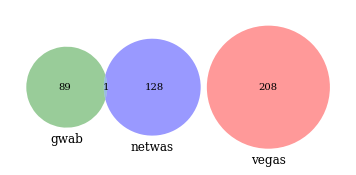

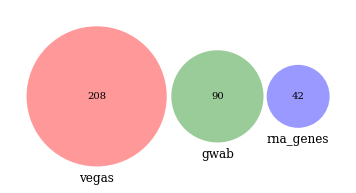

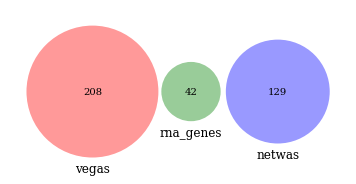

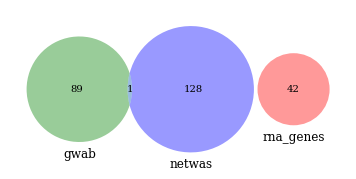

In [324]:
rna_genes = rna_df.index.tolist()

plt.figure()
matplotlib_venn.venn3([set(vegas_sig_genes),set(gwab_genes),set(g_netwas)],set_labels=['vegas','gwab','netwas'])

plt.figure()
matplotlib_venn.venn3([set(vegas_sig_genes),set(gwab_genes),set(rna_genes)],set_labels=['vegas','gwab','rna_genes'])

plt.figure()
matplotlib_venn.venn3([set(vegas_sig_genes),set(rna_genes),set(g_netwas)],set_labels=['vegas','rna_genes','netwas'])

plt.figure()
matplotlib_venn.venn3([set(rna_genes),set(gwab_genes),set(g_netwas)],set_labels=['rna_genes','gwab','netwas'])